In [72]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Attention, BatchNormalization, Concatenate, Input, TimeDistributed, Add
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.utils import plot_model  # For model diagram
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, LayerNormalization
from tensorflow.keras.regularizers import l2


In [73]:
# Load the datasets

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

### Explore the training data

In [74]:
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [75]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [76]:
# Data types and missing values

print("\nData Types:")
print(train.dtypes)
print("\nMissing Values per Column:")
print(train.isnull().sum())


Data Types:
No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype: object

Missing Values per Column:
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


In [77]:
# Summary Statistics (detailed)
print("\nSummary Statistics for Training Data:")
print(train.describe(include='all'))


Summary Statistics for Training Data:
                  No          DEWP          TEMP          PRES           Iws  \
count   30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std      8855.542765      0.994087      1.015193      1.008991      1.018337   
min         1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%      7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%     15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%     23007.250000      0.913358      0.864984      0.832865      0.005216   
max     30676.000000      1.814055      2.340578      2.877939     11.231956   



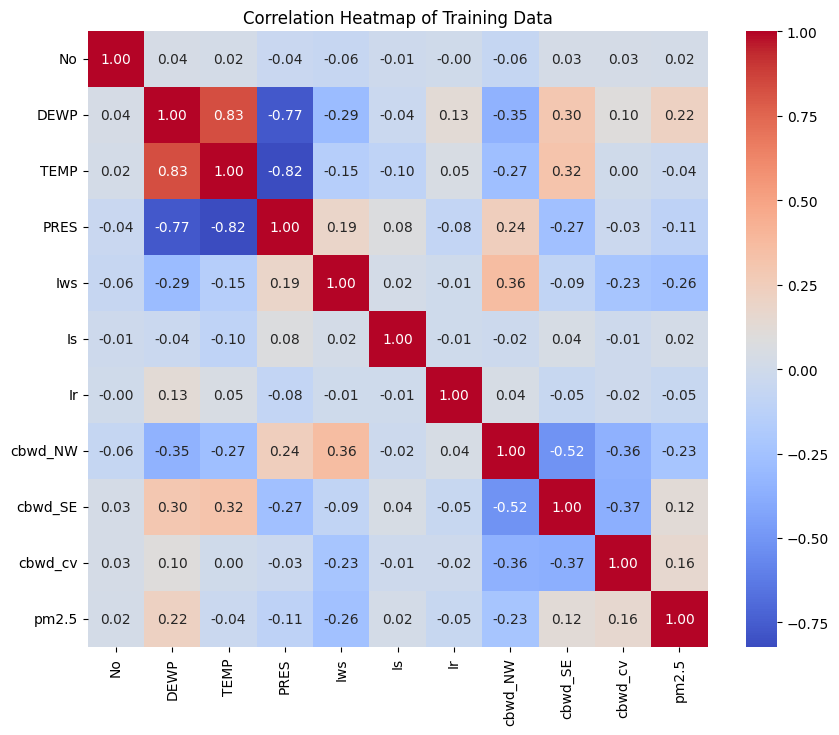

The correlation heatmap helps identify which features are strongly correlated with PM2.5 and with each other.


In [78]:
# Correlation heatmap to see the relationships between numeric features

plt.figure(figsize=(10, 8))
numeric_train = train.select_dtypes(include=['number'])
correlation_matrix = numeric_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Training Data')
plt.show()
print("The correlation heatmap helps identify which features are strongly correlated with PM2.5 and with each other.")

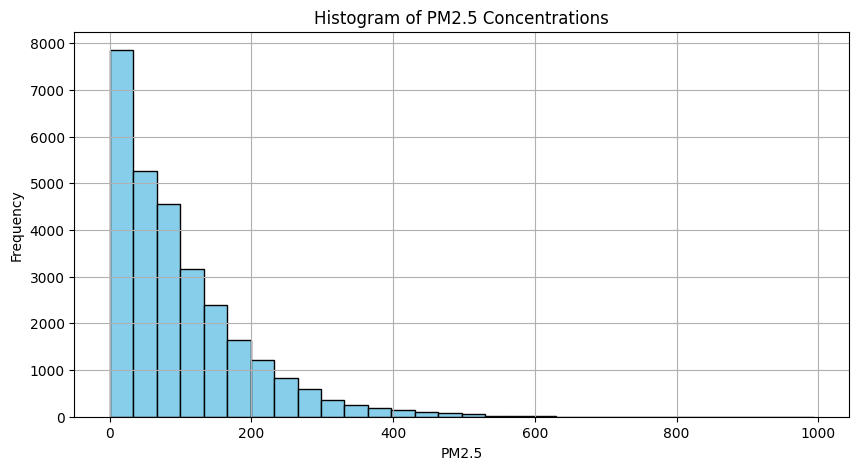

The histogram of PM2.5 concentrations shows its distribution, helping to identify skewness and potential outliers.


In [79]:
# Histogram for PM2.5 (target)

plt.figure(figsize=(10, 5))
plt.hist(train['pm2.5'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of PM2.5 Concentrations')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print("The histogram of PM2.5 concentrations shows its distribution, helping to identify skewness and potential outliers.")

In [80]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

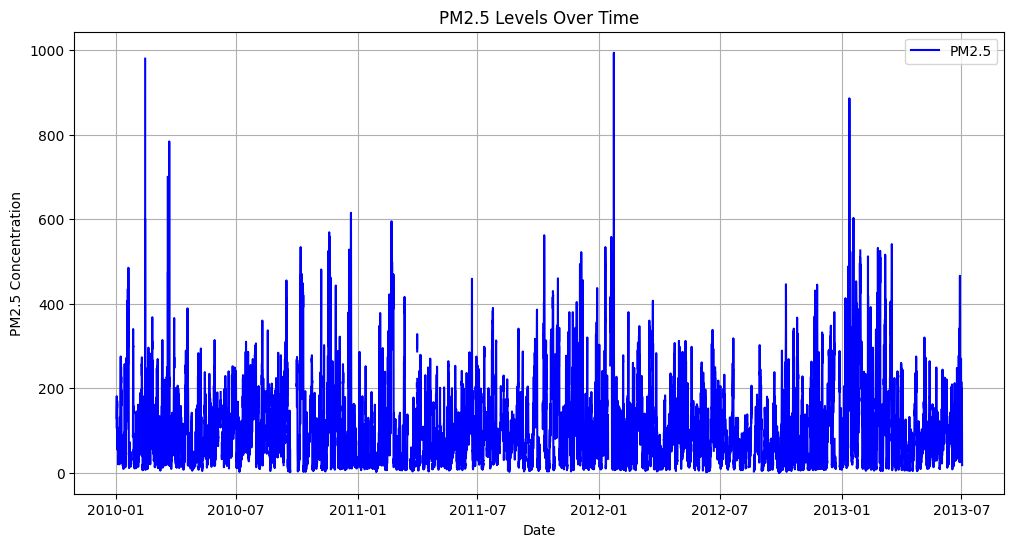

The time series plot illustrates trends and seasonal patterns in PM2.5 levels over time.


In [81]:
# Time Series Plot of PM2.5

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pm2.5'], color='blue', label='PM2.5')
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()
print("The time series plot illustrates trends and seasonal patterns in PM2.5 levels over time.")

## handle a missing values 

In [82]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# Features and target 

In [83]:
# lets see columns of train
print(train.columns)

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5'],
      dtype='object')


In [84]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [85]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

## Build a model

In [91]:
# Define the model
model_2 = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
    BatchNormalization(),
    
    # Added extra LSTM layer
    Bidirectional(LSTM(48, return_sequences=True, dropout=0.3)),
    BatchNormalization(),

    Bidirectional(LSTM(32, dropout=0.3)),
    BatchNormalization(),
    
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model_2.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model_2.summary()

c:\Users\thinkBIG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Lets train the model

In [92]:
# Train the model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint('best_model_2.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history_2 = model_2.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=35,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13968.0977 - rmse: 117.7874

204/204 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 13951.6074 - rmse: 117.7148 - val_loss: 14340.0137 - val_rmse: 119.7498 - learning_rate: 0.0010
Epoch 2/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7076.2339 - rmse: 84.1114

204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 7075.7485 - rmse: 84.1086 - val_loss: 10109.3193 - val_rmse: 100.5451 - learning_rate: 0.0010
Epoch 3/35
202/204 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6863.4624 - rmse: 82.8430

204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6862.4512 - rmse: 82.8369 - val_loss: 8903.3193 - val_rmse: 94.3574 - learning_rate: 0.0010
Epoch 4/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6655.0293 - rmse: 81.5719

204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6655.0293 - rmse: 81.5719 - val_loss: 8257.2266 - val_rmse: 90.8693 - learning_rate: 0.0010
Epoch 5/35
202/204 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6484.3120 - rmse: 80.5113

204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 6484.5176 - rmse: 80.5128 - val_loss: 7995.6299 - val_rmse: 89.4183 - learning_rate: 0.0010
Epoch 6/35
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6441.2578 - rmse: 80.2518

204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6440.9937 - rmse: 80.2502 - val_loss: 7903.6904 - val_rmse: 88.9027 - learning_rate: 0.0010
Epoch 7/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6301.0986 - rmse: 79.3739 - val_loss: 8170.0947 - val_rmse: 90.3886 - learning_rate: 0.0010
Epoch 8/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6244.5537 - rmse: 79.0143 - val_loss: 8357.7021 - val_rmse: 91.4205 - learning_rate: 0.0010
Epoch 9/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6269.1851 - rmse: 79.1443 - val_loss: 8147.9155 - val_rmse: 90.2658 - learning_rate: 5.0000e-04
Epoch 10/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6434.1318 - rmse: 80.2016

204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6433.4302 - rmse: 80.1972 - val_loss: 7851.2393 - val_rmse: 88.6072 - learning_rate: 5.0000e-04
Epoch 11/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6489.0483 - rmse: 80.5377 - val_loss: 8162.1294 - val_rmse: 90.3445 - learning_rate: 5.0000e-04
Epoch 12/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6404.4272 - rmse: 80.0106 - val_loss: 8095.0449 - val_rmse: 89.9725 - learning_rate: 5.0000e-04
Epoch 13/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6212.4736 - rmse: 78.8150 - val_loss: 8041.0063 - val_rmse: 89.6717 - learning_rate: 2.5000e-04
Epoch 14/35
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6129.0664 - rmse: 78.2798 - val_loss: 7924.9370 - val_rmse: 89.0221 - learning_rate: 2.5000e-04


959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


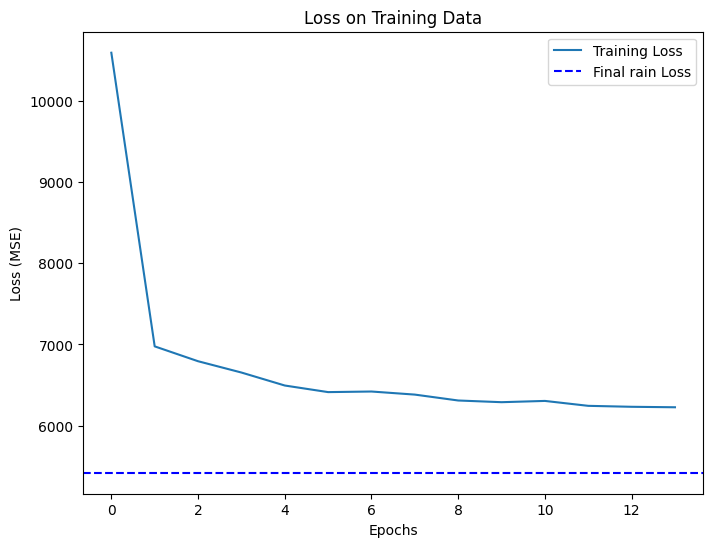

Final Training Loss (MSE): 5422.915941829013
Final RMSE on Training Data: 73.64045044558739


In [93]:
# Calculate training loss
train_predictions = model_2.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history_2.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final RMSE on Training Data: {np.sqrt(train_loss)}")

# Submissions on Kaggle

In [94]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test data
predictions = model_2.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission dataframe
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %H:%M:%S').str.replace(r'(?<=\s)0(\d):', r'\1:', regex=True),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission dataframe by the row ID
submission = submission.sort_values(by='row ID')

# Save the submission dataframe to a CSV file
submission.to_csv('../submissions/submission7.csv', index=False)
print("Submission saved to 'submission.csv'.")


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Submission saved to 'submission.csv'.
